In [271]:
from Udep2Mono.polarization import PolarizationPipeline
import networkx as nx
import matplotlib.pyplot as plt
import binarytree as bt
from wordnet import find_relation, get_word_sets
from PIL import Image, ImageDraw
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
import json
import _pickle as pickle
import os
import gensim.downloader as api


In [225]:
#G = Ugraph()
nounModifiers = {"det", "nummod", "amod","obl:tmod", "acl:relcl", "nmod", "case","nmod:pass",  "acl", "Prime"}
verbModifiers = {"advmod", "obl","xcomp","advcl","mark"}
nounCategories = {"compound"}
verbs = {"VBZ", "VBP", "VBD", "VBG"}
modified = {"NN", "PRP", "JJ", "VB"}.union(verbs)
modifiers = nounModifiers.union(verbModifiers)
offFocus = {"expl"}
contents = {"nsubj","obj","cop","compound","conj", "cc", "aux","nsubj:pass"}
cont_npos = {"nsubj":'nn', "obj": 'nn', "cop": 'vbz', "verb": 'vbz'}
mark_toProp = {"+": {"hyponym","synonym"}, "-": {"hypernym","synonym"}, "=": {"synonym"}}
clause_prop = {"which", "that", "who"}
be_verbs = {"is", "am", "are", "be"}
directions = {0: "lexical", 1: "phrasal", 2: "syntatic_variation", 3: "implicative"}

In [3]:
#G.add_node("ok",id=1)
#G.add_node("fine")

In [303]:
#nx.draw(G, with_labels=True)
sentenceset = ["This are 2 specially cool dog food", "Animal cut fresh meat carefully every month"]
test1 = ["A lady cuts some meat", "A woman cuts some meat"]
testWhich = ["a lady who is beautiful drives a car that is old ", "A beautiful woman drives a old car"]
testAnd = ["A girl eats an pear and an orange", "A girl makes and eats an apple", "A girl and a boy are carefully writing homework"]
testWith = ["A girl carries the bag with a tie", "A girl with a costume eats an apple", "A boy shocks the dog under the roof"]
testThere = ["There is a girl with a bag", "Here is the homework that I just wrote", "This is the pizza that I just ordered"]
testExtract = ["The beautiful girl who is wearing a bowtie and sitting on the chair eats a pretty pear", "The pretty woman wearing a bowtie eats a pear", "The beautiful girl eats a pear that has beautiful marks"]
test2 = ["A dog is eating food", "A dog is blue"] 
testToComp = ["The person who is beautiful swims to exercise", "The person studys at noon to take an exam", "The pretty woman wearing a bowtie eats a pear to take an exercise"]
#det order
#add word/modifier
#"and" in connection 

In [5]:
arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}
def annotation2string(annotation):
    annotated = list(annotation['annotated'].popkeys())
    def compose_token(word):
        if '-' in word[0]:
            orig = word[0].split('-')
            return ' '.join([x + arrows[word[2]] for x in orig])
        else:
            return word[0] + arrows[word[2]]
    annotated_sent = ' '.join([compose_token(x) for x in annotated])
    return annotated_sent

In [325]:
pipeline = PolarizationPipeline(verbose = 1)
results = []
results_tree = []
for sent in testToComp:
    tree = pipeline.single_polarization(sent)["polarized_tree"]
    results_tree.append(tree)
    results.append(pipeline.postprocess(tree,""))
print(results)

['[nsubj↑  [det=  [DT  the↑]  [acl:relcl=  [nsubj=  [WP  who=]  [cop=  [VBZ  is=]  [JJ  beautiful=]]]  [NN  person=]]]  [xcomp↑  [mark↑  [TO  to↑]  [VB  exercise↑]]  [VBZ  swims↑]]]', '[nsubj↑  [det=  [DT  the↑]  [NN  person=]]  [advcl↑  [mark↑  [TO  to↑]  [obj↑  [det↑  [DT  an↑]  [NN  exam↑]]  [VB  take↑]]]  [obl↑  [case↑  [IN  at↑]  [NN  noon↑]]  [VBZ  studys↑]]]]', '[nsubj↑  [det=  [DT  the↑]  [acl=  [obj=  [det=  [DT  a=]  [NN  bowtie=]]  [VBG  wearing=]]  [amod=  [JJ  pretty=]  [NN  woman=]]]]  [advcl↑  [mark↑  [TO  to↑]  [obj↑  [det↑  [DT  an↑]  [NN  exercise↑]]  [VB  take↑]]]  [obj↑  [det↑  [DT  a↑]  [NN  pear↑]]  [VBZ  eats↑]]]]']


In [283]:
class Unode:
    def __init__(self,prop,word,npos, mark):
        self.nexts = dict()
        self.prop = prop
        self.isRoot = False
        self.nexts["all"] = set()
        self.word = word
        self.npos = npos
        self.mark = mark
        self.phrases = set()
        self.pair = -1
        self.pairParts = dict()
        self.start = -1
        self.end = -1
        self.nodes = set()
    def add_Unode(self, node):
        #print(node.prop)
        if(self.isRoot):
            self.nexts[node.prop].add(node)
        else:
            self.nexts["all"].add(node)
    def addNode(self, node):
        self.nodes.add(node)
    def getText(self):
        if(self.isRoot):
            output = ""
            for cont in ["nsubj", "verb","obj"]:
                for ele in self.nexts[cont]:
                    output += ele.getText()
                    output += " "
            return output.strip()
        else:
            if(self.nexts["all"] == set()):
                return self.word
            output = self.word
            for element in self.nexts["all"]:
                if(element.prop == "amod"):
                    output = " " + output
                    output =  element.getText() + output
                else:
                    output += " "
                    output +=  element.getText()
                
            return output
    def get_inText(self, index):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        connected_info += (key + ": " + keyItem.get_inText(index + 1) + " ")
            return "{ " + connected_info + "}"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info += node.get_inText(index + 1)
            return "{ The " + str(index) + " layer" + ": " + self.word + connected_info + "}"
    def get_magicText(self):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                component = ""
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        component += " (" + keyItem.get_magicText() + ")"
                    component = "(" + key + " " + component + ")"
                connected_info += component
            return "(" + connected_info + ")"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    #print("111")
                    connected_info +=  "(" + node.get_magicText() + ")"
            if(self.nexts["all"] == set()):
                if(self.pair != -1):
                    return self.word + str(self.pair)
                return self.word
            if(self.pair != -1):
                    return self.word + str(self.pair) + connected_info
            return  self.word + connected_info
    def addNum(self,num):
        self.pair = num
    def addPart(self, newNode, type1):
        if(type1 not in self.pairParts):
            self.pairParts[type1] = set()
        self.pairParts[type1].add(newNode)
    def getParts(self):
        ### return verb-obj subParts now
        return self.pairParts["obj"]

In [9]:
class PairCounter:
    def __init__(self, initial = 0):
        self.nsubj = initial 
        self.obj = initial
    def incrementN(self):
        self.nsubj += 1
    def incrementO(self):
        self.obj += 1

In [282]:
class Ugraph:
    def __init__(self, rootNode):
        self.root = rootNode
        self.root.isRoot = True
        self.root.nexts.pop("all",None)
        for main in {"nsubj", "obj", "verb"}:
            self.root.nexts[main] = set()
        self.nodes = set()
        self.contentSet = set()
        self.chunks = set()
        self.Pairs = dict()
        self.Pairs["nsubj"] = dict()
        self.Pairs["obj"] = dict()
    def add_node(self,node):
        self.nodes.add(node)
        self.root.addNode(node)
    def add_edge(self, node1, node2):
        if(node1.isRoot):
            self.contentSet.add(node2.word)
        node1.add_Unode(node2)
    def contains(self, word_assigned):
        return word_assigned in self.contentSet
    def get_magicText(self):
        return self.root.get_magicText()
    def addPair(self, newNode, num,type1):
        newNode.addNum(num)
        if(num not in self.Pairs[type1]):
            self.Pairs[type1][num] = [None]
        if(newNode.prop == "verb"):
            self.Pairs[type1][num][0] = newNode
        else:
            self.Pairs[type1][num].append(newNode)
        if(len(self.Pairs[type1][num]) > 1 and self.Pairs[type1][num][0] is not None):
            if(newNode.prop == "verb"):
                self.Pairs[type1][num][0].addPart(self.Pairs[type1][num][-1],"obj")
            else:
                self.Pairs[type1][num][0].addPart(newNode, "obj")

In [11]:
def print_as_graph(tree):
    G = nx.DiGraph()
    construct_treeGraph(tree,G)
    #G.add_node("this",id=2)
    nx.draw_planar(G, with_labels=True)

In [12]:
def print_tree_simple(tree):
    if(tree == "N"):
        return bt.Node("Not a Tree")
    root = bt.Node(tree.val)
    construct_tree(tree, root)
    print(root)

In [13]:
def construct_treeGraph(tree,G):
    if(tree == "N"):
        return
    else:
        if(tree.left != "N"):
            
            G.add_node(tree.left.val,id=1)
            G.add_edge(tree.val, tree.left.val)
            construct_treeGraph(tree.left,G)
        if(tree.right != "N"):
            #print(tree.right.npos==None)
            G.add_node(tree.right.val,id=1)
            G.add_edge(tree.val, tree.right.val)
            construct_treeGraph(tree.right,G)

In [14]:
def construct_tree(tree, subtree):
    if(tree == "N"):
        return
    if(tree.left != "N"):
        subtree.left = bt.Node(tree.left.val)
        construct_tree(tree.left, subtree.left)
    if(tree.right != "N"):
        subtree.right = bt.Node(tree.right.val)
        construct_tree(tree.right, subtree.right)
    

In [15]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [16]:
def visualize_tree(tree):
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

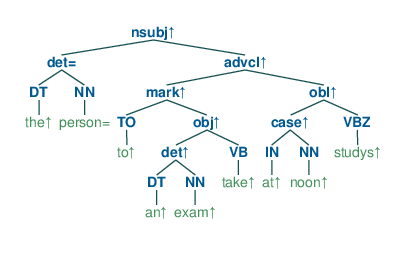

In [327]:
#print_as_graph(results[0][4])
visualize_tree(results[1])
#print_tree_simple(results[0][4])

In [18]:
def draw_graph():
    output = Image.new("RGB", (500, 500), (255,255,255))
    draw = ImageDraw.Draw(output)
    #draw.ellipse([100,100,200,200])
    draw.multiline_text((100, 100), "aaabbb\nword", fill=(0,0,0))
    output.show()

In [19]:
#draw_graph()

In [20]:
class graph_Info():
    def __init__(self,graph,crucials):
        self.graph = graph
        self.crucials = crucials

In [21]:
def mono2Graph(sent_info):
    G = Ugraph(Unode("root", "Root","r00t","="))
    #extract_NOV(sent_info, G)
    #print(G.root.nexts)
    #print(sent_info)
    counter = PairCounter()
    mono2Graph_recur(sent_info, G, set(),"verb",counter) ### root directly assigned for test here
    return G

In [22]:
def printUgraph_inText(Ugraph):
    print(Ugraph.root.get_inText(1))

In [25]:
G = mono2Graph(results_tree[1])
print(results_tree[0] == None)
printUgraph_inText(G)
print(len(G.nodes))
for node_p in G.nodes:
    print(node_p.word+ "222")
print(G.root.nexts.keys())

False
verb
nsubj
obj
{ verb: { The 2 layer: eats} verb: { The 2 layer: makes} nsubj: { The 2 layer: girl{ The 3 layer: a}} obj: { The 2 layer: apple{ The 3 layer: an}} }
6
apple222
a222
makes222
an222
eats222
girl222
dict_keys(['verb', 'nsubj', 'obj'])


In [ ]:
# def extract_NOV(sent, G):
#     if(sent == "N"):
#         return
#     #print(sent.npos)
#     if((sent.val in contents or sent.npos in verbs) and not(sent.val in G.root.nexts.keys())):
#         print(sent.npos)
#         if sent.npos in verbs and sent.parent.val not in {"cop"}:
#             tempNode = Unode("verb", sent.val)
#         else:
#             if (sent != "N"):
#                 print(sent.val)
#             else:
#                 print(sent)
#             currentNode = sent.left
#             while(currentNode.right != "N"):
#                 currentNode = currentNode.right
#             tempNode = Unode(sent.val,currentNode.val)
#             G.add_node(tempNode)
#             G.add_edge(G.root, tempNode)
#             if(sent.val == "cop"):
#                 currentNode = sent.right
#                 while(currentNode.right != "N"):
#                     if(currentNode.val == "compound"):
#                         tempNode1 = Unode("obj",currentNode.left.val + " " + currentNode.right.val)
#                         G.add_node(tempNode1)
#                         G.add_edge(G.root, tempNode1)
#                         return
#                     currentNode = currentNode.right
#                 tempNode1 = Unode(sent.val,currentNode.val)
#                 G.add_node(tempNode1)
#                 G.add_edge(G.root, tempNode1)
        
#     #if(sent.val == "obj"):
#         #extract_NOV(sent.left, G)
#     extract_NOV(sent.right, G)

In [274]:
def mono2Graph_recur(sent_tree, G, mods, pos = None, counter = -1):
    needleft = True
    needright = True
    if(sent_tree is None):
        
        return
    #print(sent_tree.val)
    # 
    #if(sent_tree.nposif(sent_tree.val == "compound"):
    #         compound_out = sent_tree.left.val+" " + sent_tree.right.val
    #         G.add_node(compound_out)
    #         G.add_edge(root,compound_out)
    #         #ls.append(compound_out)
            
    #         return != None):
        #print(sent_tree.val + " " + sent_tree.parent.val)
        # if((sent_tree.npos in modified and sent_tree.npos != "JJ") or (sent_tree.parent!= "N" and sent_tree.parent.val == "nsubj")):
        #     ls.append(sent_tree.val)
        #     #G.add_node(sent_tree.val)
        #     G.add_node(sent_tree.parent.val,name=sent_tree.val)
        #     G.add_edge(root, sent_tree.parent.val)
        #     #G.add_edge(sent_tree.parent.val, sent_tree.val)
    #    print("")
    else:
        #print(sent_tree.val)
        if(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(modifiers))))):
            if("acl" in sent_tree.val):
                G_prime = mono2Graph(sent_tree.left)
                mods.add(G_prime.root)
            else:
                left_result = mono2Graph_recur(sent_tree.left, G, set(), sent_tree.val,counter)
                if(left_result is not None):
                    mods.add(left_result)
            #print("000000000")
            #for item_print in mods:
            #    if(item_print!=None):
            #        print(item_print.word)
            #print("000000000")
            return mono2Graph_recur(sent_tree.right, G, mods, pos,counter)            
        else:
            if ((sent_tree.left is None and sent_tree.right is None) or sent_tree.val == "compound" ):
                    if(sent_tree.val == 'and'):
                        return
                    if(sent_tree.val == "compound"):
                        newNode = Unode(pos, sent_tree.left.val + "-" + sent_tree.right.val,
                                        sent_tree.pos, sent_tree.mark)
                        newNode.start = sent_tree.left.id
                        newNode.end = sent_tree.right.id
                        if(pos in contents or pos == "verb"):
                                G.add_edge(G.root,newNode)
                                if(pos != "nsubj"):
                                    G.addPair(newNode, counter.obj,"obj")
                        for node in mods:
                                G.add_edge(newNode, node)
                        return newNode
                    newNode = Unode(pos, sent_tree.val, sent_tree.pos, sent_tree.mark)
                    newNode.start = sent_tree.id
                    newNode.end = sent_tree.id
                    G.add_node(newNode)
                    if (any(list(map(lambda x : sent_tree.pos is not None and x in sent_tree.pos, list(modified)))) 
                                                        or any(list(map(lambda x: pos is not None and x in pos, list(contents))))
                                                            or pos == "verb"):
                        if(pos in contents or pos == "verb"):
                            # if(pos in G.root.nexts.keys()):
                            #     print(G.root.nexts.keys())
                            #     print(pos)
                            #     print("Error occured in concentrating contents")
                            # else:
                                G.add_edge(G.root,newNode)
                                if(pos != "nsubj"):
                                    G.addPair(newNode, counter.obj,"obj")
                                    if(pos == "verb"):
                                        counter.incrementO()
                        for node in mods:
                            #if(G.contains(sent_tree.val)):
                                # loc = ""
                                # if(sent_tree.npos in verbs):
                                #     loc = "verb"
                                # else:
                                #     for key_cont in G.root.nexts.keys():
                                #         if(key_cont != "all"):
                                #             if(G.root.nexts[key_cont].word == sent_tree.val):
                                #                 loc = key_cont
                                #                 break
                                G.add_edge(newNode, node)
                        return newNode
                    else:
                        mods.add(newNode)
                        return newNode
            else: 
                if(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(contents))))):
                    pos_left = sent_tree.val
                    pos_right = pos
                    if("nsubj" in sent_tree.val):
                        pos_right = "verb"
                        pos_left = sent_tree.val[0:5]
                    if("cop" in sent_tree.val):
                        pos_left = "verb"
                        pos_right = "obj"
                    if('conj' in sent_tree.val):
                        mono2Graph_recur(sent_tree.left, G, set(), pos,counter)
                        
                        mono2Graph_recur(sent_tree.right, G, mods, pos,counter)
                    elif("aux" in sent_tree.val):
                        mono2Graph_recur(sent_tree.right, G, mods, "verb",counter)
                    elif("obj" in sent_tree.val and pos != "verb"):
                        right_result = mono2Graph_recur(sent_tree.right, G, set(), "Prime",counter)
                        if(right_result is not None):
                            mods.add(right_result)
                        mono2Graph_recur(sent_tree.left, G, mods, pos_left, counter)
                    else:
                        mono2Graph_recur(sent_tree.left, G,set(),pos_left,counter)
                        mono2Graph_recur(sent_tree.right, G, mods, pos_right,counter)
                elif(any(list(map(lambda x: sent_tree.val is not None and x in sent_tree.val, list(offFocus))))):
                    mono2Graph_recur(sent_tree.right, G, mods, pos,counter)
    #if(needleft):
    #    mono2Graph_recur(sent_tree.left, G, mods)
    #if(needright):
    #    mono2Graph_recur(sent_tree.right, G, mods)

In [ ]:
#def mono2Graph_categorize(sent_tree, G, root):
    

In [ ]:
# def find_nearest_belongTo(sent_tree, G, content_mark):
#     if(sent_tree == "N"):
#         print("Seems to have a parsing or binarization error")
#         return "", -2
#     if(sent_tree.npos == None):
#         if(sent_tree.val == "compound"):
#             comp_node = sent_tree.left.val + " " + sent_tree.right.val
#             if(comp_node in G.['dict'].keys()):
#                 print(comp_node)
#                 #G.nodes["C1"]['dict'].update({comp_node: content_mark})

#             return sent_tree, 2
#         return find_nearest_belongTo(sent_tree.right,G,content_mark)

#     elif (sent_tree.npos in modified or sent_tree.val in {"this", "these", "there", "that"} ):
#         if(sent_tree.parent.val in contents):
#             key = sent_tree.val
#             #print(sent_tree.val)
#             G.nodes["C1"]['dict'].update({key: sent_tree.parent.val})
#         return sent_tree, 1
#     else: 
#         print(sent_tree.val)
#         return "", -1

In [26]:
#graph_out1 = mono2Graph(results[0])
#graph_out2 = mono2Graph(results[0])
#print(graph_out2.graph.nodes['obl:tmod'])
#nx.draw(graph_out2.graph, with_labels=True,center="C1")

In [27]:
"compound" == ("a" or "compound" )

False

verb
nsubj
obj
{ verb: { The 2 layer: swims{ The 3 layer: exercise{ The 4 layer: to}}} nsubj: { The 2 layer: person{ The 3 layer: the}} }
verb
nsubj
obj
{ verb: { The 2 layer: studys{ The 3 layer: noon{ The 4 layer: at}}} nsubj: { The 2 layer: person{ The 3 layer: the}} obj: { The 2 layer: exam{ The 3 layer: to}{ The 3 layer: take}{ The 3 layer: an}} }
verb
nsubj
obj


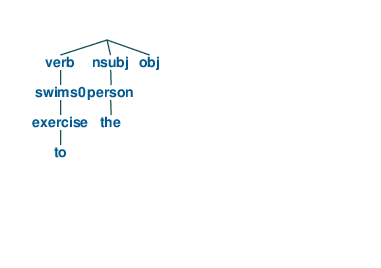

verb
nsubj
obj


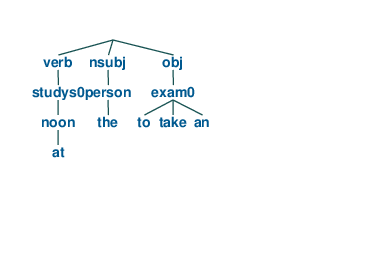

dict_keys(['verb', 'nsubj', 'obj'])


In [234]:
G1 = mono2Graph(results_tree[0])
G2 = mono2Graph(results_tree[1])
#print(results_tree[0].left)
#print(results_tree[0].left.left is None)
printUgraph_inText(G1)
printUgraph_inText(G2)
jupyter_draw_nltk_tree(Tree.fromstring(G1.get_magicText()))
jupyter_draw_nltk_tree(Tree.fromstring(G2.get_magicText()))
print(G.root.nexts.keys())

In [29]:
def check_alignment(graph1, graph2):
    return check_alignByRoot(graph1.root, graph2.root)

In [30]:
def check_alignByRoot(root1, root2):
    for cont in {"nsubj", "verb", "obj"}:
        if(not(check_cont(root1, root2, cont))):
            print(cont)
            return "UnAligned"
    return "Aligned"  

In [31]:
def check_cont(root1, root2, cont):
    core1 = root1.nexts[cont]
    core2 = root2.nexts[cont]
    return depth_check(core1, core2)


In [32]:
def depth_check(node1, node2):
    if(node1.isRoot and node2.isRoot):
        return check_alignByRoot(node1, node2)
    if(node1.isRoot or node2.isRoot):
        return compare_nodeGraph(node1, node2)
    if(node1.pos != node2.pos and not(node1.pos in verbs and node2.pos in verbs)): 
        #currently on lexical level of comparison
        print(1)
        return False
    # if(len(node1.nexts["all"]) != len(node2.nexts["all"])):
    #     #currently only caring about equal numebr of qualifiers
    #     print(2)
    #     return False
    if(node1.mark != node2.mark):
        #currently only caring about same mark
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(3)
        return False
    if((find_relation(node1.word, node2.word, node1.pos) not in mark_toProp[node1.mark]) and node1.word != node2.word):
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(find_relation(node1.word, node2.word, node1.pos))
        print(4)
        return False
    for next1 in node1.nexts["all"]:
        corr_found = False
        for next2 in node2.nexts["all"]:
            if(next1.word == "Root"):
                print(next2.word)
            if(depth_check(next1, next2)):
                corr_found = True
                break
        if(not(corr_found)):
            print(5)
            print(next1.word)
            return False
    return True

A group of friends are riding the current in a raft
This group of people is practicing water safety and wearing preservers


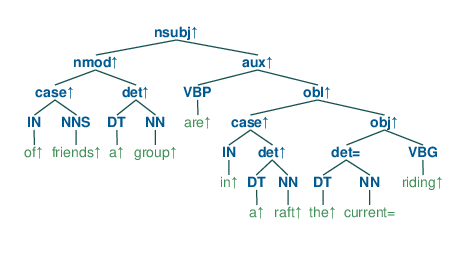

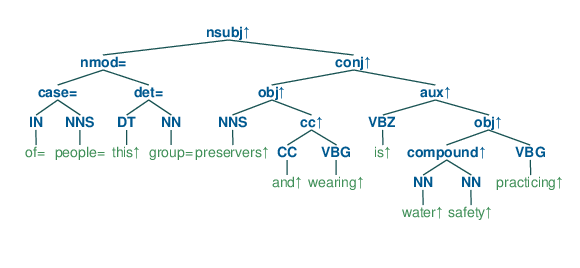

verb
nsubj
obj
((verb  (riding0(raft(a)(in))))(nsubj  (group(friends(of))(a)))(obj  (current0(the))))
verb
nsubj
obj
((verb  (wearing0) (practicing1))(nsubj  (group(this)(people(of))))(obj  (water-safety1) (preservers0)))
verb
nsubj
obj


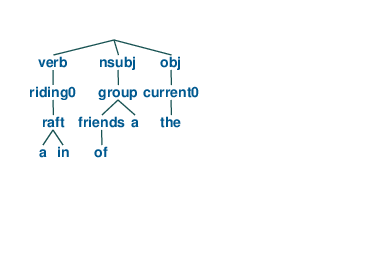

verb
nsubj
obj


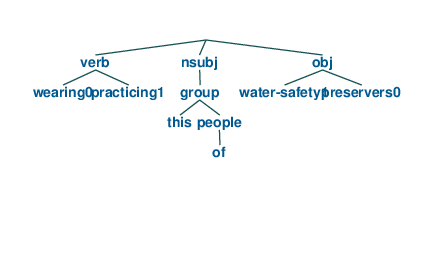

verb
nsubj
obj
{ verb: { The 2 layer: riding{ The 3 layer: raft{ The 4 layer: a}{ The 4 layer: in}}} nsubj: { The 2 layer: group{ The 3 layer: friends{ The 4 layer: of}}{ The 3 layer: a}} obj: { The 2 layer: current{ The 3 layer: the}} }
verb
nsubj
obj
{ verb: { The 2 layer: wearing} verb: { The 2 layer: practicing} nsubj: { The 2 layer: group{ The 3 layer: this}{ The 3 layer: people{ The 4 layer: of}}} obj: { The 2 layer: water-safety} obj: { The 2 layer: preservers} }


<function TextIOWrapper.close()>

In [158]:
file = open("../data/SICK/train.txt", "r")
lines = file.readlines()
indexStart = 0
output = []
fileOut = open("./sickEntailment.txt", "w")
fileOut1 = open("./sickContradiction.txt", "w")
pipeline = PolarizationPipeline(verbose = 1)
# results = []
# results_tree = []
# for sent in testExtract:
#     tree = pipeline.single_polarization(sent)["polarized_tree"]
#     results_tree.append(tree)
#     results.append(pipeline.postprocess(tree,""))
# print(results)
i = 1
testNum = 65
for line in lines:
    if(i==testNum):
        # if(indexStart < 1):
        #     indexStart = indexStart + 1
        # else:
        argArr = line.split("\t")
        if(1):#argArr[4]=="ENTAILMENT\n"):
            #output.append(learn_variation(argArr[1], argArr[2], argArr[3], argArr[4][0:len(argArr[4])-2]))
            print(argArr[1])
            print(argArr[2])
            tree1 = pipeline.single_polarization(argArr[1])["polarized_tree"]
            tree2 = pipeline.single_polarization(argArr[2])["polarized_tree"]
            visualize_tree(pipeline.postprocess(tree1,""))
            visualize_tree(pipeline.postprocess(tree2,""))
            graph1 = mono2Graph(tree1)
            graph2 = mono2Graph(tree2)
            print(graph1.get_magicText())
            print(graph2.get_magicText())
            jupyter_draw_nltk_tree(Tree.fromstring(graph1.get_magicText()))
            jupyter_draw_nltk_tree(Tree.fromstring(graph2.get_magicText()))
            printUgraph_inText(graph1)
            printUgraph_inText(graph2)
                
            fileOut.write(line)
        if(argArr[4] == "CONTRADICTION\n"):
            fileOut1.write(line)
        
    elif(i>testNum): 
        break
    i+=1
#print(output)
file.close
fileOut.close
fileOut1.close

In [34]:
def compare_nodeGraph(node, node2):
    if(node.isRoot):
        root = node
        wordNode = node2
    else:
        root = node2
        wordNode = node
    if(root.nexts["verb"].word in be_verbs):
        
        for adjs in {root.nexts["obj"]}:
            if(depth_check(wordNode, adjs)):
                return True
        return False

In [35]:
def check_branch(node1, node2, label = "all"):
    if(node1.word != node2.word or len(node1.nexts) != len(node2.nexts)):
        return False
    toRemove = set()
    for next1 in node1.nexts[label]:
        cor = False
        for next2 in node2.nexts[label]:
                if(next1.word == next2.word and check_branch(next1, next2)):
                    cor = True
                    node2.nexts[label].remove(next2)
                    break
        if(cor):
            toRemove.add(next1)
    #print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True
    else:
        
        return False
                    

In [36]:
def extract_syntatic_var(node1, node2):
   if (node2 == None):
       return node1.getText(),-1
   if (node1 == None):
       return -1, node2.getText()
   if(node1.nexts["all"] == set() or node2.nexts["all"] == set()):
       return -1, -1
   return node1.getText(), node2.getText()

In [37]:
def learn_variation(sent1, sent2, score, rel):
    graph1 = mono2Graph(sent1)
    graph2 = mono2Graph(sent2)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    root1 = graph1.root
    root2 = graph2.root
    for cont in root1.nexts.keys():
        check_branch(root1, root2, cont)
        fileOut = open("./" + cont + "SyntacticVar" + ".txt", "w")
        list_ref1 = list(root1.nexts[cont])
        list_ref2 = list(root2.nexts[cont])
        size_iter = max(len(list_ref1), len(list_ref2))
        line1 = dict()
        line2 = dict()
        for i in range(size_iter):
            
            result1, result2 = extract_syntatic_var(list_ref1[i] if i < len(list_ref1) else None, list_ref2[i] if i < len(list_ref2) else None)
            if(result1 != -1):
                if(list_ref1[i].word not in line1.keys()):
                    line1[list_ref1[i].word] = set()
                line1[list_ref1[i].word].add(result1)
            if(result2 != -1):
                if(list_ref2[i].word not in line2.keys()):
                    line2[list_ref2[i].word] = set()
                line2[list_ref2[i].word].add(result2)
        print(line1,file=fileOut)
        print("\t",file=fileOut)
        print(line2,file=fileOut)
        print("\n",file=fileOut)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    return 2
#Problem with "and" in main cores alignment
#Problem with aligning different forms of the same word (i.e eat/eats, apple/apples, a/an)

In [38]:
# def det_branch(graph1, graph2, label = "all"):
#     for
        

In [245]:
def insert_byOrder(nodeList, totalList):
    index = 0
    for i in range(len(totalList)):
        if(nodeList[-1].end < totalList[i][0].start):
            break
        index += 1
    totalList.insert(index,nodeList)
    return index

In [246]:
A = [3]
A[-1]
A.insert(1,[3,5])
A[0:1]

[3]

In [258]:
def check_nodesForChunk(nodeList, center, total):
    size = len(nodeList)
    splitpos = [0,size]
    for j in range(size -1):
        if(nodeList[j][-1].end + 1 != nodeList[j+1][0].start):
            if(j < center):
                if(j >= splitpos[0]):
                    splitpos[0] = j
            else:
                if((j+1) < splitpos[1]):
                    splitpos[1] = j+1
    outList = nodeList[splitpos[0]:splitpos[1]]
    newList = []
    for k in range(len(outList)):
        for node in outList[k]:
            newList.append(node)
    total.append(newList)
    return newList

In [288]:
def construct_sentence(root):
    listNodes = list(root.nodes)
    output = []
    for k in range(len(root.nodes)):
        index = 0
        for i in range(len(output)):
            if(listNodes[k].end < output[i].start):
                break
            index += 1
        output.insert(index,listNodes[k])
    return output

In [289]:
def chunk_from_nodes(node, results):
    if(node.isRoot):
        make_chunks(node, results)
        #considering chunks from clause unrelated to main clause now
        output = construct_sentence(node)
        results.append(output)
        return output
    if(node.nexts["all"] == set()):
        return [node]
    ##sorting goes:
    tempList = []
    for nodeItem in node.nexts["all"]:
        result = chunk_from_nodes(nodeItem, results)
        if(result is not None):
            insert_byOrder(result, tempList)
    center = insert_byOrder([node],tempList)
    return check_nodesForChunk(tempList, center, results)
    
    

In [262]:
def make_chunks(graph_or_root, results):
    if(type(graph_or_root) is Ugraph):
        root = graph_or_root.root
    else:
        root = graph_or_root
    for cont in root.nexts.keys():
        for contNode in root.nexts[cont]:
            chunk_from_nodes(contNode, results)
    outList = []
    for nodeList in results:
        tempStr = ""
        for node in nodeList:
            tempStr += node.word
            tempStr += " "
        outList.append(tempStr.rstrip())
    return outList

['a bowtie', 'wearing a bowtie', 'the pretty woman wearing a bowtie', 'to take an exercise', 'a pear']


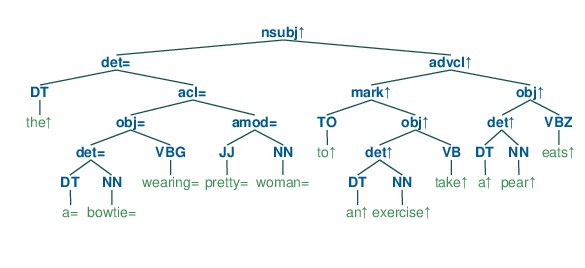

13
10
verb
nsubj
verb
nsubj
obj
obj


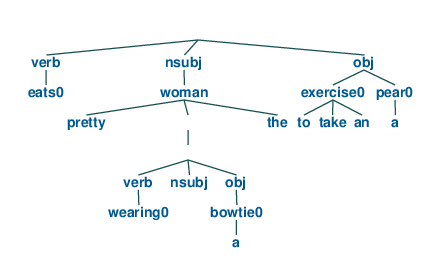

In [305]:
results = []
gh1 = mono2Graph(results_tree[2])
print(make_chunks(gh1, results))
visualize_tree(pipeline.postprocess(results_tree[2],""))
print(results_tree[1].right.right.right.key)
print(results_tree[1].right.right.left.left.key)

jupyter_draw_nltk_tree(Tree.fromstring(gh1.get_magicText()))

In [ ]:
print("s" + None + "test")

In [ ]:
def chunk_extract(graph1):
    

In [ ]:
test111 = [1,2,3]
test222 = dict()
test222["app"] = [1,5]
test222.toString()
print(test222)
#test111[4]
print(0 if 1>0 else 1)

In [ ]:
learn_variation(results_tree[0], results_tree[2], 4.0, "entailment")

In [313]:
def process_branch(node1, node2, label = "all"):
    if(node1.isRoot == True and node2.isRoot == True and label == "all"):
            noun,potentialNouns = process_branch(node1, node2, "nsubj")
            verb,potentialVerbs = process_branch(node1, node2, "verb")
            obj,potentialObjs = process_branch(node1, node2, "obj")
            nodes = [node1, node2]
            for i in range(2):
                for toRmverb in potentialVerbs:
                    for toRmobj in potentialObjs:
                        if(toRmverb[i].pair == toRmobj[i].pair and toRmverb[i].pair != -1):
                            nodes[i].nexts["verb"].remove(toRmverb[i])
                            nodes[i].nexts["obj"].remove(toRmobj[i])
            return noun and verb and obj, None
    if(node1.isRoot != node2.isRoot):
        print("Node relating in process_branch() breaks")
        return False,None
    toRemove = set()
    toRemoveContentWords = []
    for next1 in node1.nexts[label]:
        cor = False
        
        for next2 in node2.nexts[label]:
                ###alignment of roots lacking
                if((next1.isRoot == next2.isRoot) and (next1.isRoot or w2v_model.similarity(next1.word,next2.word) > 0.8)):
                    tempBool, tempOut = process_branch(next1, next2)
                    if(tempBool):
                        if(label != "all"):

                            toRemoveContentWords.append([next1,next2])
                            break
                        cor = True
                        node2.nexts[label].remove(next2)
                        break
        if(cor):
            toRemove.add(next1)
    #print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True,toRemoveContentWords
    else:
        
        return False,toRemoveContentWords

In [293]:
def getRootNodes(node):
    output = set()
    for root in node.nexts["all"]:
        if(root.isRoot):
            output.add(root)
    return output

In [294]:
def check_differenceOld(node1, node2, ranks):
    #indexs: 0->lexical 1->phrasal 2->syntatic variation 3->implicative
    if(not node1.isRoot and not node2.isRoot):
        roots1 = getRootNodes(node1)
        roots2 = getRootNodes(node2)
        rootPassed = set()
        for root1 in roots1:
            for root2 in roots2:
                outRank = control_direct(root1, root2)[1]
                ranks += outRank
                node2.nexts["all"].remove(root2)
                rootPassed.add(root1)
                break
        for passedRoot in rootPassed:
            roots1.remove(passedRoot)
    
    for nextNode1 in node1.nexts["all"]:
        
        related = []
        
        if(node2.nexts["all"] == set()):
            if(nextNode1.isRoot):
                ranks[2] += 1
            else:
                ranks[nextNode1.nexts["all"] != set()] += 1
            continue
        for nextNode2 in node2.nexts["all"]:
            #print(nextNode2.nexts)
            if_related = False
            if(nextNode1.isRoot != nextNode2.isRoot):
                if_related = True
                ranks[2] += 1
                break
            if(nextNode1.nexts["all"] == set() and nextNode2.nexts["all"] == set()):
               
                if_related = True
                if(nextNode1.word == nextNode2.word):
                    ranks[0] += 1
                break
            related.append(nextNode2)
        if(if_related):
            node2.nexts["all"].remove(nextNode2)
            related = []
        if(related != []):
            alignedNode = related[0]
            if(nextNode1.nexts["all"] == set()):
                ranks[2] += 1
            else:
                if(related[0].nexts["all"] == set()):
                    ranks[2] += 1
                else:
                    next_set = [0] * 4
                    check_difference(nextNode1, alignedNode, next_set)
                    sum = sum(next_set)
                    if(sum > 1):
                        if(nextNode1.word != alignedNode.word):
                            ranks[2] += 1
                        else:
                            ranks[1] += 1
                    elif((sum == 1) != (nextNode1.word != alignedNode.word)):
                        ranks[0] += 1
                    elif(sum ==1):
                        ranks[1] += 1 ##or simply ranks[0] += 2
                    else:
                        print("Error in check_difference because of process_branch")
                node2.nexts["all"].remove(related[0])
    if(node2.nexts["all"] != set()):
        for node2_left in node2.nexts["all"]:
            if(node2_left.isRoot):
                ranks[2] += 1
            else:
                ranks[node2_left.nexts["all"] != set()] += 1
        


In [295]:
def cal_sim_nodes(node1, node2, prop = 1.0):
    #node1,node2 both sets or both nodes
    ###not considering root with root case
    if(type(node1) is not set and type(node2) is not set and (node1.isRoot or node2.isRoot)):
        return 0
    if(type(node1) is set):
        set1 = node1
    else:
        set1 = node1.nexts["all"]
    if(type(node2) is set):
        set2 = node2
    else:
        set2 = node2.nexts["all"]
    if(set1 == set() or set2 == set()):
        if(type(node1) is not set):
            return prop * w2v_model.similarity(node1.word, node2.word)
        return 0
    nextSizes = min(len(set1), len(set2))
    tracked = set()
    outputRank = 0
    for nodeNext1 in set1:
        tempMax = [None, 0]
        for nodeNext2 in set2:
            if nodeNext2 not in tracked:
                rank = cal_sim_nodes(nodeNext1, nodeNext2, prop*0.4/nextSizes)
                if(rank >= tempMax[1]):
                    tempMax[0] = nodeNext2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            break
        tracked.add(tempMax[0])
        outputRank += tempMax[1]
    if(type(node1) is set):
        return outputRank
    return 0.6*prop*w2v_model.similarity(node1.word, node2.word) + outputRank
        
        

In [321]:
def check_difference(node1, node2, ranks,pos = "all"):
    #indexs: 0->lexical 1->phrasal 2->syntatic variation 3->implicative
    #currently not experted on how a node might be aligned to a root node
    if(not node1.isRoot and not node2.isRoot):
        roots1 = getRootNodes(node1)
        roots2 = getRootNodes(node2)
        rootPassed = set()
        rootPassed1 = set()
        for root1 in roots1:
            tempMaxRoot = [None, 0]
            for root2 in roots2:
                if(root2 not in rootPassed):
                    rank3 = cal_sim_nodes(root1, root2)
                    if(rank3 >= tempMaxRoot[1]):
                        tempMaxRoot[0] = root2
                        tempMaxRoot[1] = rank3
            if(tempMaxRoot[0] is not None):
                rootPassed.add(tempMaxRoot[0])
                outRank = control_direct(root1, root2)[1]
                for i in range(len(outRank)):
                    ranks[i] += outRank[i]
            else:
                rootPassed1.add(root1)
                break
            rootPassed1.add(root1)
        for passedRoot in rootPassed:
            print(pos)
            print(list({itemTemp.word:1 for itemTemp in node1.nexts[pos]}))
            print(passedRoot.word)
            node2.nexts[pos].remove(passedRoot)
        for root1 in rootPassed1:
            node1.nexts[pos].remove(root1)
    
    nextSizes = min(len(node1.nexts[pos]), len(node2.nexts[pos]))
    tracked = set()
    
    for nextNode1 in node1.nexts[pos]:
        
        related = []
        if(nextNode1.isRoot):
            continue
        if(node2.nexts[pos] == set()):
            if(nextNode1.isRoot):
                ranks[2] += 1
            else:
                ranks[1] += 1
            continue
        tempMax = [None, 0]
        for nextNode2 in node2.nexts[pos]:
            if nextNode2 not in tracked and not nextNode2.isRoot:
                rank = cal_sim_nodes(nextNode1, nextNode2, 0.4/nextSizes)
                if(rank >= tempMax[1]):
                    tempMax[0] = nextNode2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            ###not mapping node and root node here
            
            for nodeRoot in node2.nexts[pos]:
                if(nodeRoot not in trakced):
                    root2 = nodeRoot
                    break
            ranks[2] += 1
            tracked.add(root2)
            break
        tracked.add(tempMax[0])
        alignedNode = tempMax[0]
        
        if(nextNode1.nexts["all"] == set()):
            ranks[alignedNode.nexts["all"] != set()] += 1
            
        else:
            if(alignedNode.nexts["all"] == set()):
                ranks[nextNode1.nexts["all"] != set()] += 1                    
            else:
                next_set = [0] * 4
                check_difference(nextNode1, alignedNode, next_set)
                #if(nextNode1.word == "woman"):

                    #print("At node with word(woman): ")
                    #print(len(node1.nexts[pos]))
                    #print(next_set)
                    #print(len(node2.nexts[pos]))
                sumOut = sum(next_set)
                if(sumOut > 1):
                    if(nextNode1.word != alignedNode.word):
                        ##node words not equal and descendents some are different
                        ranks[2] += 1
                    else:
                        ranks[1] += 1
                elif((next_set[0] == 1 and nextNode1.word == alignedNode.word) or 
                    (sumOut == 0 and nextNode1.word != alignedNode.word)):
                    ranks[0] += 1
                elif(sumOut ==1):
                    ranks[1] += 1 ##or simply ranks[0] += 2
                else:
                    print(sumOut)
                    print(nextNode1.word)
                    print(alignedNode.word)
                    
                    print("Error in check_difference because of process_branch")
        
    if(len(node2.nexts[pos]) != len(tracked)):
        for node2_left in node2.nexts[pos]:
            if(node2_left not in tracked):
                if(node2_left.isRoot):
                    ranks[2] += 1
                else:
                    ranks[1] += 1

In [306]:
def control_direct(sent1, sent2, isRoot = True):
    if(not(isRoot)):
        graph1 = mono2Graph(sent1)  
        graph2 = mono2Graph(sent2)
        root1 = graph1.root
        root2 = graph2.root
    else:
        root1 = sent1
        root2 = sent2
        
    diffs = [0] * 4
    process_branch(root1, root2)
    check_difference(root1, root2, diffs, "nsubj")
    
    tracked = set()
    for verbNode1 in root1.nexts["verb"]:         
        tempMax = [None, 0]
        for verbNode2 in root2.nexts["verb"]:
            if verbNode2 not in tracked:
                print(verbNode1.word)
                print(verbNode2.word)
                rank = cal_sim_nodes(verbNode1, verbNode2, 0.6) + cal_sim_nodes(verbNode1.getParts(), verbNode2.getParts(), 0.4)
                if(rank >= tempMax[1]):
                    tempMax[0] = verbNode2
                    tempMax[1] = rank
        if(tempMax[0] is None):
            if(verbNode1.isRoot):
                diffs[2] += 1
            else:
                diffs[1] += 1
            continue
        tracked.add(tempMax[0])
        check_difference(verbNode1, tempMax[0], diffs)
        ###only check the first obj node with verb now
        if(verbNode1.getParts() != set() and verbNode2.getParts() != set()):
            check_difference(next(iter(verbNode1.getParts())), next(iter(tempMax[0].getParts())), diffs)
            ##print("AfterObj:")
            ##print(diffs)
    if(len(root2.nexts["verb"]) != len(tracked)):
        for node2_left in root2.nexts["verb"]:
            if(node2_left not in tracked):
                if(node2_left.isRoot):
                    diffs[2] += 1
                else:
                    diffs[1] += 1
    return [directions[diffs.index(max(diffs))] ,diffs]

In [ ]:
for i in range(3):
   test = 1
print(test) 

In [298]:
w2v_model = api.load("glove-wiki-gigaword-50")

In [308]:
w2v_model.similarity("girl", "woman")

0.906528

The beautiful girl who is wearing a bowtie and sitting on the chair eats a pretty pear
The pretty woman wearing a bowtie eats a pear
0.88336843


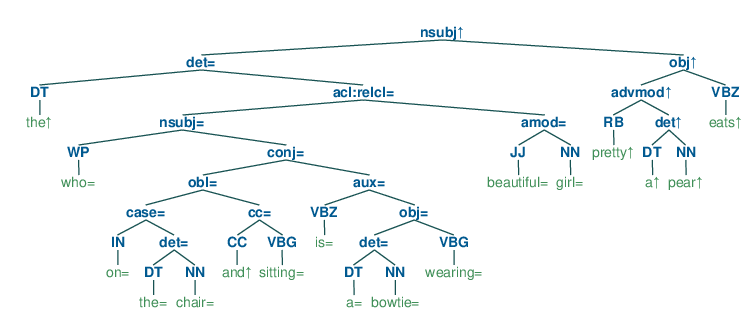

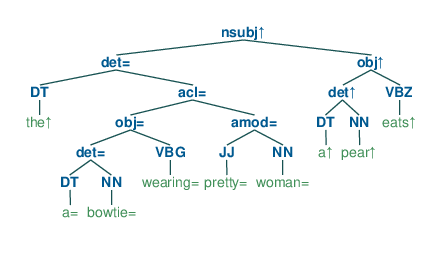

verb
nsubj
verb
nsubj
obj
obj


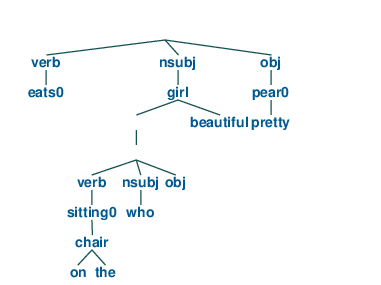

verb
nsubj
verb
nsubj
obj
obj


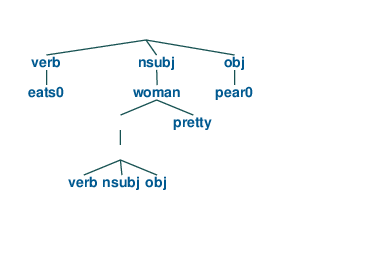

RESULT:
all
['Root', 'beautiful']
Root
At node with word(woman): 
eats
eats
[0, 1, 1, 0]
ABOVE IS RESULT


In [320]:
#print(control_direct(results_tree[0], results_tree[1],False))
print(testExtract[0])
print(testExtract[1])


print(w2v_model.similarity('car','vehicle'))

tree1 = pipeline.single_polarization(testExtract[0])["polarized_tree"]
tree2 = pipeline.single_polarization(testExtract[1])["polarized_tree"]
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree1,"").replace('[', '(').replace(']', ')')))
jupyter_draw_nltk_tree(Tree.fromstring(pipeline.postprocess(tree2,"").replace('[', '(').replace(']', ')')))
g1 = mono2Graph(tree1)
g2 = mono2Graph(tree2)
process_branch(g1.root,g2.root)
jupyter_draw_nltk_tree(Tree.fromstring(g1.get_magicText()))
jupyter_draw_nltk_tree(Tree.fromstring(g2.get_magicText()))
print("RESULT:")
print(control_direct(tree1, tree2,False)[1])
print("ABOVE IS RESULT")



In [ ]:
print(w2v_model.similarity("fruit", "banana"))
print(w2v_model.similarity( "apple", "banana"))
w2v_model.similarity("fruit","apple")

In [ ]:
dict1 = {1:"2"}
dict1[1]

In [ ]:
A = {2,4}
print(i for i in A)
B = [3,5]
B[1!=0] += 1
print(B)

In [ ]:
list({None, 5})

In [ ]:
test1 = Unode("root", "root", "root", "root")
testSet = set()
testSet.add(test1)
testSet.remove(test1)
testSet

In [ ]:
#get_word_sets("car","hypernym")

In [ ]:
check_alignment(G1, G2)

In [ ]:
ae = set()
def return1(i):
    return
ae.add(return1(2))
ae

In [ ]:
find_relation("woman", "lady", "nn")

In [ ]:
find_relation("people","person",'nn')

In [ ]:
if(1==0):
    t = 3
else:
    t = 5
print(t)

In [ ]:
None == None